In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from gloss_d import GlobalLossD
from dice_loss import DiceLoss
from seg_unet import UNet_pretrained, UNet
import torch.nn.functional as F

import json
import statistics
from sklearn.metrics import f1_score
import pickle
import copy

from training_utils import *
from data_augmentation_utils import DataAugmentation

torch.cuda.empty_cache()

with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
with open('configs/seg_unet_ACDC.json') as config_file:
    config_seg = json.load(config_file)
with open('configs/config_encoder.json') as config_file:
    config_encoder = json.load(config_file)

In [2]:
# baseline 
n_vol_train = 2
n_vol_val = 2
n_vol_test = 12
option = 'baseline'#, 'option_2', 'option_3', 'option_4', 'option_5', 'option_6', 'option_7'] 
loss_unet = config_seg['loss_unet']
run = 0 
seed = 0


dataset = config_seg['dataset']
resize_size = config_seg['resize_size']
n_channels = config_seg['n_channels']
max_epochs = config_seg['max_epochs']
max_steps = config_encoder['max_steps']
n_classes = config_seg['n_classes']
batch_size = config_seg['batch_size']
lr = config_seg['lr']
weight_pretrained = config_seg['weight_pretrained']


save_global_path = config_seg['save_global_path']

In [3]:
def test_loading(config_datasets, config_seg, dataset, total_n_volumes=24, n_volumes=2, 
                       split_set = 'train',shuffle = False, idx_vols_val = None, return_idx = False):
    img_dataset = []
    mask_dataset = []
        
    idx_vols = select_random_volumes(total_n_volumes, n_volumes) 
    if idx_vols_val != None :
        assert len(idx_vols_val) + n_volumes <= total_n_volumes
        while any(item in idx_vols for item in idx_vols_val) :
            idx_vols = select_random_volumes(total_n_volumes, n_volumes) 
            
    count = -1
    
    for config_dataset in config_datasets :
        if config_dataset['Data'] == dataset :  
            for path in Path(config_dataset['savedir']+ split_set +'/').rglob('subject_*/'):
                
                # We want total path not individual path of images
                if "nii.gz" in str(path) or ".png" in str(path) :
                    continue
                count += 1   
                
                # Different criterion to stop adding train or test volumes
                if split_set == 'test':
                    if count >= n_volumes :
                        break
                else :
                    if count not in idx_vols :
                        continue
                        
                # Add the image and the corresponding mask to the datasets
                for path_image in path.rglob("img.nii.gz") :
                    img_dataset.append(path_image)
                    print(path_image)
                for path_mask in path.rglob("mask.nii.gz") :
                    mask_dataset.append(path_mask)
    
    return img_dataset, mask_dataset

In [4]:
img_dataset, mask_dataset = test_loading(config_datasets, config_seg, dataset, total_n_volumes=n_vol_test, 
                                        n_volumes=n_vol_test, split_set = 'test', 
                                        shuffle = False)
print('Test set')
# dataset_loader_test = initialize_dataset(config_datasets, config_seg, dataset, total_n_volumes=n_vol_test, 
#                                          n_volumes=n_vol_test, split_set = 'test', 
#                                          shuffle = False)
subj_label = 72

../img_cropped/acdc/test/subject_84/img.nii.gz
../img_cropped/acdc/test/subject_91/img.nii.gz
../img_cropped/acdc/test/subject_63/img.nii.gz
../img_cropped/acdc/test/subject_66/img.nii.gz
../img_cropped/acdc/test/subject_92/img.nii.gz
../img_cropped/acdc/test/subject_16/img.nii.gz
../img_cropped/acdc/test/subject_33/img.nii.gz
../img_cropped/acdc/test/subject_72/img.nii.gz
../img_cropped/acdc/test/subject_3/img.nii.gz
../img_cropped/acdc/test/subject_29/img.nii.gz
../img_cropped/acdc/test/subject_94/img.nii.gz
../img_cropped/acdc/test/subject_20/img.nii.gz
Test set


In [5]:
# baseline 
n_vol_train = 2
n_vol_val = 2
option = 'baseline'#, 'option_2', 'option_3', 'option_4', 'option_5', 'option_6', 'option_7'] 
loss_unet = config_seg['loss_unet']
run = 1
seed = 0


dataset = config_seg['dataset']
resize_size = config_seg['resize_size']
n_channels = config_seg['n_channels']
max_epochs = config_seg['max_epochs']
max_steps = config_encoder['max_steps']
n_classes = config_seg['n_classes']
batch_size = config_seg['batch_size']
lr = config_seg['lr']
weight_pretrained = config_seg['weight_pretrained']


save_global_path = config_seg['save_global_path']

if dataset == 'Abide':
    n_classes = 15
    lab = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    weights = torch.tensor([0.025, 0.075, 0.075, 0.035, 0.035, 0.075, 0.075, 0.075, 
                                   0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075], dtype=torch.float32)
    
    total_n_volumes = 24
    n_vol_test = 12
    
elif dataset == 'CIMAS' or dataset == 'ACDC' :
    n_classes = 4
    lab = [1,2,3]
    weights = torch.tensor([0.1, 0.3, 0.3, 0.3], dtype=torch.float32)
    
    if dataset == 'CIMAS' :
        total_n_volumes = 13
        n_vol_test = 7
    else :
        total_n_volumes = 69
        n_vol_test = 30

if option == 'baseline' :
    pretraining = 'baseline'

elif option == 'option_1':
    save_models_pretrain = save_global_path + "pretrainings" + \
                            "/global_dminus/" + \
                            "/MMWHS_HCP_Chaos_MedDecath Prostate_3volumesPerBatch/"
    pretraining = 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
elif option == 'option_2':
    save_models_pretrain = save_global_path +  "pretrainings" + \
                           "/global_dminus/" + \
                            "MMWHS_ACDC_6volumesPerBatch/predictions"
    pretraining = 'pretrained with MMWHS-ACDC (global_dminus)' 

save_models_path = save_global_path + dataset + '/' + pretraining + '/batch_size_' + str(batch_size)  + \
                '/'+ loss_unet +'_lr_'+ str(lr) + '_' + str(n_vol_train) + '_vol_in_train_'  + str(n_vol_val)  + \
                 '_vol_in_val' + '/run_' + str(run)

In [6]:
print('Using : ')
print(pretraining)
print('dataset : ',dataset)
print('max_epochs : ', max_epochs)
print('max_steps : ', max_steps)
print('batch_size : ', batch_size)
print('n_vol_train : ', n_vol_train)
print('n_vol_val : ', n_vol_val)
print('n_vol_test : ', n_vol_test)
print('loss unet : ', loss_unet)
print('lr : ', lr)
print('save_models_path : ', save_models_path)
print('current run : ', str(run) , ' with seed : ',  str(seed))

Using : 
baseline
dataset :  ACDC
max_epochs :  10000
max_steps :  2500
batch_size :  16
n_vol_train :  2
n_vol_val :  2
n_vol_test :  30
loss unet :  crossentropy_loss
lr :  0.001
save_models_path :  ./trained_models/ACDC/baseline/batch_size_16/crossentropy_loss_lr_0.001_2_vol_in_train_2_vol_in_val/run_1
current run :  1  with seed :  0


In [7]:
best_model = UNet(config_seg)
for path in Path(str(save_models_path) + '/save_models/').rglob('checkpoints_best_model*.pt'):
    print(path)
    checkpoint = torch.load(path, map_location=torch.device('cpu') )
    best_model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

trained_models/ACDC/baseline/batch_size_16/crossentropy_loss_lr_0.001_2_vol_in_train_2_vol_in_val/run_1/save_models/checkpoints_best_model553.pt


In [8]:
def only_numerics(seq):
    seq_type= type(seq)
    return seq_type().join(filter(seq_type.isdigit, seq))


In [9]:
f1_mean = []
f1_arr = []

with torch.no_grad():
    best_model.to(device)
    best_model.eval()

    batch_test_loss = []
    f1_mean = []
    f1_arr = []
    #for id_batch, (batch_x, batch_y) in enumerate(tqdm(dataset_loader_test)):
    for i in range(len(img_dataset)) :
        if str(img_dataset[i])  == '../img_cropped/acdc/test/subject_'+str(subj_label)+'/img.nii.gz':
            print(img_dataset[i])
            vol_file= img_dataset[i]
            mask_file = mask_dataset[i]

            volume_data = nib.load(vol_file)
            mask_data = nib.load(mask_file)

            affine_volume = volume_data.affine
            affine_mask = mask_data.affine

            volume = volume_data.get_fdata()
            mask = mask_data.get_fdata()

            assert volume.shape == mask.shape

            batch_x = torch.from_numpy(volume.transpose(2, 0, 1))
            batch_y = torch.from_numpy(mask.transpose(2, 0, 1))

            test_batch_x = (batch_x.float().to(device)).view((-1, n_channels, *resize_size))
            test_batch_y = (batch_y.long().to(device)).view((-1, n_channels, *resize_size))

            pred = best_model(test_batch_x)
            pred_labels_baseline = F.softmax(pred, dim=1) 
            pred_labels_baseline = torch.argmax(pred_labels_baseline, dim=1)

            f1_val = compute_f1(test_batch_y.cpu(), pred_labels_baseline.cpu(), lab)
            f1_mean.append(np.mean(f1_val))
            f1_arr.append(f1_val)
            baseline_mean_score = np.mean(f1_val)
            print('f1 scores : ', f1_val)
            print('mean dice score : ', baseline_mean_score )



            pred_labels_baseline = pred_labels_baseline.detach().numpy().transpose(1,2,0)
            labels = nib.Nifti1Image(pred_labels_baseline, affine_mask)
            save_dir = save_models_path + '/labels_predicted/subject_' +  str(only_numerics(str(img_dataset[i])[-20:])) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/label.nii.gz'
            nib.save(labels, img_filename)
print(np.mean(f1_mean))

../img_cropped/acdc/test/subject_72/img.nii.gz
f1 scores :  [0.49382468 0.76083219 0.81827609]
mean dice score :  0.6909776512702256
0.6909776512702256


In [10]:
option = 'option_1'#, 'option_2', 'option_3', 'option_4', 'option_5', 'option_6', 'option_7'] 

if option == 'baseline' :
    pretraining = 'baseline'

elif option == 'option_1':
    save_models_pretrain = save_global_path + "pretrainings" + \
                            "/global_dminus/" + \
                            "/MMWHS_HCP_Chaos_MedDecath Prostate_3volumesPerBatch/"
    pretraining = 'pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)'
save_models_path = save_global_path + dataset + '/' + pretraining + '/batch_size_' + str(batch_size)  + \
                '/'+ loss_unet +'_lr_'+ str(lr) + '_' + str(n_vol_train) + '_vol_in_train_'  + str(n_vol_val)  + \
                 '_vol_in_val' + '/run_' + str(run)        
print('Using : ')
print(pretraining)
print('dataset : ',dataset)
print('max_epochs : ', max_epochs)
print('max_steps : ', max_steps)
print('batch_size : ', batch_size)
print('n_vol_train : ', n_vol_train)
print('n_vol_val : ', n_vol_val)
print('n_vol_test : ', n_vol_test)
print('loss unet : ', loss_unet)
print('lr : ', lr)
print('save_models_path : ', save_models_path)
print('current run : ', str(run) , ' with seed : ',  str(seed))


best_model = UNet(config_seg)
for path in Path(str(save_models_path) + '/save_models/').rglob('checkpoints_best_model*.pt'):
    print(path)
    checkpoint = torch.load(path, map_location=torch.device('cpu') )
    best_model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

f1_mean = []
f1_arr = []
with torch.no_grad():
    best_model.to(device)
    best_model.eval()

    batch_test_loss = []
    f1_mean = []
    f1_arr = []
                    
    for i in range(len(img_dataset)) :
    #for id_batch, (batch_x, batch_y) in enumerate(tqdm(dataset_loader_test)):
        if str(img_dataset[i])  == '../img_cropped/acdc/test/subject_'+str(subj_label)+'/img.nii.gz':
            print(img_dataset[i])
            vol_file= img_dataset[i]
            mask_file = mask_dataset[i]

            volume_data = nib.load(vol_file)
            mask_data = nib.load(mask_file)

            affine_volume = volume_data.affine
            affine_mask = mask_data.affine

            volume = volume_data.get_fdata()
            mask = mask_data.get_fdata()

            assert volume.shape == mask.shape

            batch_x = torch.from_numpy(volume.transpose(2, 0, 1))
            batch_y = torch.from_numpy(mask.transpose(2, 0, 1))

            test_batch_x = (batch_x.float().to(device)).view((-1, n_channels, *resize_size))
            test_batch_y = (batch_y.long().to(device)).view((-1, n_channels, *resize_size))

            pred = best_model(test_batch_x)
            pred_labels = F.softmax(pred, dim=1) 
            pred_labels = torch.argmax(pred_labels, dim=1)

            f1_val = compute_f1(test_batch_y.cpu(), pred_labels.cpu(), lab)
            f1_mean.append(np.mean(f1_val))
            f1_arr.append(f1_val)
            pretrained_mean_score = np.mean(f1_val)
            print('f1 scores : ', f1_val)
            print('mean dice score : ', pretrained_mean_score)

            pred_labels = pred_labels.detach().numpy().transpose(1,2,0)
            labels = nib.Nifti1Image(pred_labels, affine_mask)
            save_dir = save_models_path + '/labels_predicted/subject_' +  str(only_numerics(str(img_dataset[i])[-20:])) 
            Path(save_dir).mkdir(parents = True, exist_ok = True)
            img_filename = str(save_dir)+'/label.nii.gz'
            nib.save(labels, img_filename)
            print('array : ' , f1_mean)


Using : 
pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)
dataset :  ACDC
max_epochs :  10000
max_steps :  2500
batch_size :  16
n_vol_train :  2
n_vol_val :  2
n_vol_test :  30
loss unet :  crossentropy_loss
lr :  0.001
save_models_path :  ./trained_models/ACDC/pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)/batch_size_16/crossentropy_loss_lr_0.001_2_vol_in_train_2_vol_in_val/run_1
current run :  1  with seed :  0
trained_models/ACDC/pretrained with MMWHS-HCP-Chaos-MedDecath Prostate (global_dminus)/batch_size_16/crossentropy_loss_lr_0.001_2_vol_in_train_2_vol_in_val/run_1/save_models/checkpoints_best_model2089.pt
../img_cropped/acdc/test/subject_72/img.nii.gz
f1 scores :  [0.87641264 0.90368655 0.93651623]
mean dice score :  0.9055384716876151
array :  [0.9055384716876151]


In [11]:
np.mean(f1_mean)

0.9055384716876151

In [12]:
from matplotlib.gridspec import SubplotSpec
from matplotlib import colors
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

    
def visualize_data(pred_labels, pred_labels_baseline, batch_y) :    
    cmap = "jet"
    n = 8
    fact = 2
    # make a color map of fixed colors
    #cmap = colors.ListedColormap('turbo')
    bounds=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5]
    norm = colors.BoundaryNorm(bounds, 255)
    fig, axs = plt.subplots(4, n, figsize=(13,13),dpi=500)#pred_labels.shape[0], 2, figsize=(30,30))
    
    for i in range(n):#pred_labels.shape[0]) :
        x=  0
        axs[0, i].imshow(batch_x[x+i*fact,:,:], cmap = 'gray')
        axs[1, i].imshow(batch_y[x+i*fact,:,:], cmap = cmap, norm=norm)
        axs[2, i].imshow(pred_labels_baseline[:,:,x+i*fact], cmap = cmap, norm=norm)
        axs[3, i].imshow(pred_labels[:,:,x+i*fact], cmap = cmap, norm=norm)
        
        for j in range(4) :
            axs[j, i].set_axis_off()
            axs[j, i].set_title( 'slice '+str(x+i*fact))
            axs[j, i].set_aspect('equal')
        
    grid = plt.GridSpec(4, n) 
    create_subtitle(fig, grid[0, ::], 'Input images')
    create_subtitle(fig, grid[1, ::], 'Ground Truth')
    create_subtitle(fig, grid[2, ::], 'Baseline predictions , DSC = '+ str(round(baseline_mean_score, 3)))
    create_subtitle(fig, grid[3, ::], 'MMWHS-HCP-CHAOS-MDP pre-trained predictions , DSC = '+ str(round(pretrained_mean_score, 3)))
    fig.tight_layout()
    fig.set_facecolor('w')
    plt.subplots_adjust(wspace=0.0, hspace=-0.0)
    
    plt.savefig('trained_models/figures/ACDC_subject_'+str(subj_label)+'.png')
        

In [13]:
#visualize_data(pred_labels,  pred_labels_baseline, batch_y)


In [20]:
from matplotlib.gridspec import SubplotSpec
from matplotlib import colors
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

    
def visualize_data_per_slice(pred_labels, pred_labels_baseline, batch_y) :    
    cmap = "gray"
    n = 8
    fact = 10

    for n_slice in range(batch_y.shape[0]) :
        fig, axs = plt.subplots(1, 4, figsize=(13,5))#pred_labels.shape[0], 2, figsize=(30,30))

        axs[0].imshow(batch_x[n_slice,:,:], cmap = 'gray')
        axs[1].imshow(batch_y[n_slice,:,:], cmap = cmap)
        axs[2].imshow(pred_labels_baseline[:,:,n_slice,], cmap = cmap)
        axs[3].imshow(pred_labels[:,:,n_slice,], cmap = cmap)

        for j in range(4) :
            axs[j].set_axis_off()
            axs[j].set_aspect('equal')
        
        axs[0].set_title( 'Input image')
        axs[1].set_title( 'Ground Truth')
        axs[2].set_title( 'Baseline prediction')
        axs[3].set_title( 'Pre-train prediction')

        plt.savefig('trained_models/figures/ACDC_subject_'+str(subj_label)+ '/slice_' + str(n_slice) +'.png')


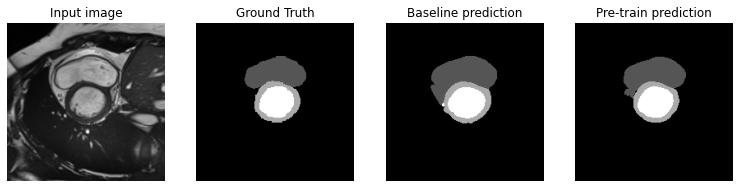

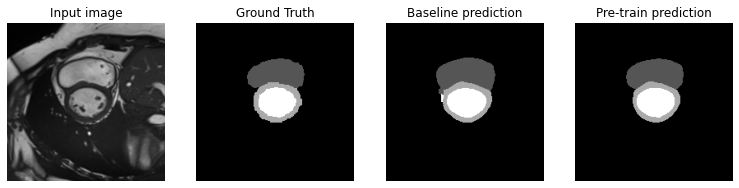

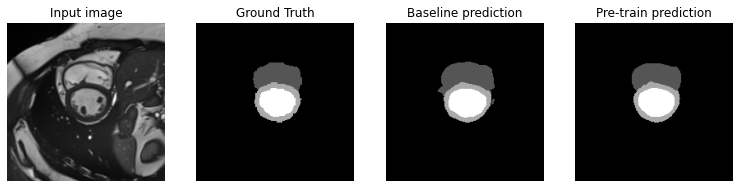

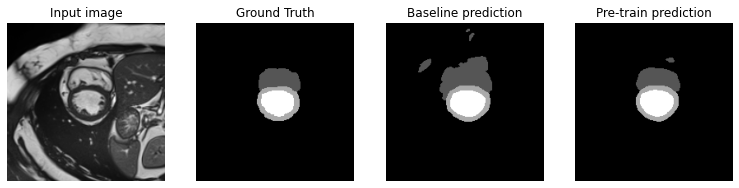

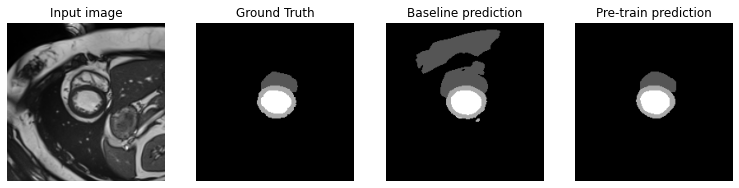

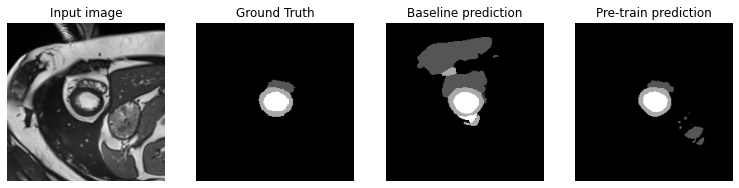

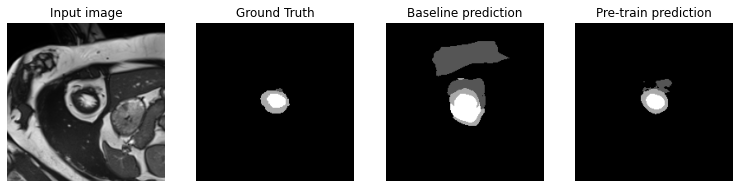

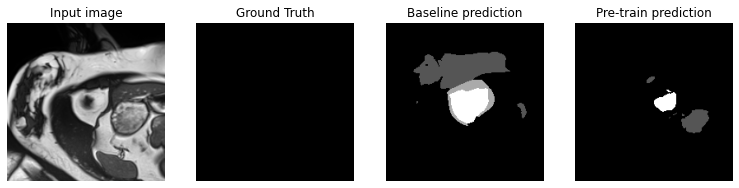

In [21]:
visualize_data_per_slice(pred_labels,  pred_labels_baseline, batch_y)